# Assigment 4

In [2]:
# files work
import os

# essentials 
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# tensorflow tools
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten

## Preperations

### Loading VGG16

In [3]:
vgg16_model = VGG16(weights='imagenet')

553467096/553467096 [==============================] - 24s 0us/step


In [4]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Loading data

In [5]:
from google.colab import drive

drive.mount("/content/gdrive", force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = os.path.join(root_dir, 'Monkey Species Data')

Mounted at /content/gdrive


In [6]:
train_dir = os.path.join(base_dir, 'Training Data')
test_dir = os.path.join(base_dir, 'Prediction Data')

In [7]:
train_dir

'/content/gdrive/My Drive/Monkey Species Data/Training Data'

In [8]:
# Get Class Names
class_names = sorted(os.listdir(train_dir))
N_CLASSES = len(class_names)

class_names

['Bald Uakari',
 'Emperor Tamarin',
 'Golden Monkey',
 'Gray Langur',
 'Hamadryas Baboon',
 'Mandril',
 'Proboscis Monkey',
 'Red Howler',
 'Vervet Monkey',
 'White Faced Saki']

In [9]:
batch_size = 32
image_size = (224,224)
epochs = 8

In [10]:
train_gen = image.ImageDataGenerator(rescale=1./255, validation_split=0.1, preprocessing_function=preprocess_input)
test_gen  = image.ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input)

In [11]:
train_data = train_gen.flow_from_directory(train_dir, target_size=image_size, batch_size=batch_size, subset='training')
val_data = train_gen.flow_from_directory(train_dir, target_size=image_size, batch_size=batch_size, subset='validation')
test_data = test_gen.flow_from_directory(test_dir, target_size=image_size, batch_size=batch_size)

Found 9000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 1306 images belonging to 10 classes.


In [12]:
X_sample = train_data.next()[0]

(-0.5, 223.5, 223.5, -0.5)

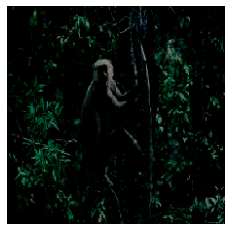

In [13]:
plt.imshow(X_sample[0])
plt.axis('off')

## Models

### First model
As a first try, I take the layer called `block5_pool`. It will have the least number of features and they should be extracted the best, which probably will result in the best performance with the least computational power. Later I will try to take prior layers and observe how it affects the results. 

In [15]:
def build_model(last_layer_name: str):
  flatten = Flatten()(vgg16_model.get_layer(last_layer_name).output)
  output_layer = Dense(N_CLASSES, activation='softmax', name='output_categorical')(flatten)
  
  model = Model(inputs=vgg16_model.input, outputs=output_layer)

  for layer in model.layers:
    if layer.name != 'output_categorical':
      layer.trainable = False

  model.summary()
  return model

In [18]:
first_model = build_model('block5_pool')

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [19]:
first_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
first_history = first_model.fit(train_data, validation_data=val_data, epochs=epochs, batch_size=batch_size)

Epoch 1/8
282/282 [==============================] - 2070s 7s/step - loss: 0.9609 - accuracy: 0.6914 - val_loss: 0.7204 - val_accuracy: 0.7780
Epoch 2/8
282/282 [==============================] - 48s 168ms/step - loss: 0.2963 - accuracy: 0.9113 - val_loss: 0.6405 - val_accuracy: 0.8160
Epoch 3/8
282/282 [==============================] - 49s 172ms/step - loss: 0.1638 - accuracy: 0.9576 - val_loss: 0.6630 - val_accuracy: 0.8080
Epoch 4/8
282/282 [==============================] - 50s 176ms/step - loss: 0.0862 - accuracy: 0.9829 - val_loss: 0.6069 - val_accuracy: 0.8270
Epoch 5/8
282/282 [==============================] - 50s 177ms/step - loss: 0.0604 - accuracy: 0.9890 - val_loss: 0.6667 - val_accuracy: 0.8270
Epoch 6/8
282/282 [==============================] - 51s 181ms/step - loss: 0.0562 - accuracy: 0.9924 - val_loss: 0.7123 - val_accuracy: 0.8200
Epoch 7/8
282/282 [==============================] - 51s 182ms/step - loss: 0.0520 - accuracy: 0.9920 - val_loss: 0.6092 - val_accuracy: 

In [20]:
x_plot = list(range(1, epochs+1))

In [21]:
# simple function to plot learning process
# tensorboard is harder to share in evaluation
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, network_history.history['loss'])
    plt.plot(x_plot, network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, network_history.history['accuracy'])
    plt.plot(x_plot, network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

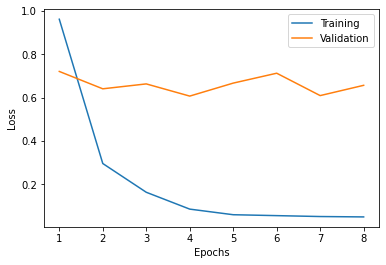

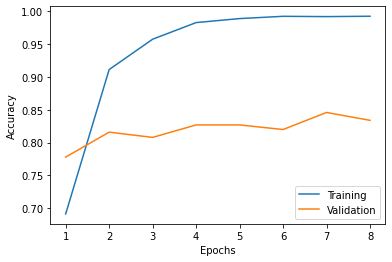

In [22]:
plot_history(first_history)

In [23]:
loss, acc = first_model.evaluate(test_data)
print("Obtained accuracy with the first model is: ", acc)
print("Obtained loss function value with the first model is: ", loss)

41/41 [==============================] - 319s 8s/step - loss: 0.5648 - accuracy: 0.8400
Obtained accuracy with the first model is:  0.8399693965911865
Obtained loss function value with the first model is:  0.5648354887962341


We can observe here a little overfitting, which could be better observed by training model with more epochs.

### Second model
Now I take part just after the fourth block. I could have chosen a convolutional layer from the fifth block since my function `build_model()` flattens the input, but to differentiate the models I am taking the `block4_pool`.

In [24]:
second_model = build_model('block4_pool')

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [25]:
second_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
second_history = second_model.fit(train_data, validation_data=val_data, epochs=epochs, batch_size=batch_size)

Epoch 1/8
282/282 [==============================] - 46s 160ms/step - loss: 10.6635 - accuracy: 0.5969 - val_loss: 8.0741 - val_accuracy: 0.7220
Epoch 2/8
282/282 [==============================] - 46s 162ms/step - loss: 2.7306 - accuracy: 0.8726 - val_loss: 7.4678 - val_accuracy: 0.7540
Epoch 3/8
282/282 [==============================] - 46s 164ms/step - loss: 1.5796 - accuracy: 0.9217 - val_loss: 10.4688 - val_accuracy: 0.7470
Epoch 4/8
282/282 [==============================] - 47s 166ms/step - loss: 1.3045 - accuracy: 0.9483 - val_loss: 10.8087 - val_accuracy: 0.7690
Epoch 5/8
282/282 [==============================] - 46s 163ms/step - loss: 1.4215 - accuracy: 0.9481 - val_loss: 11.8255 - val_accuracy: 0.7650
Epoch 6/8
282/282 [==============================] - 47s 165ms/step - loss: 1.2306 - accuracy: 0.9603 - val_loss: 12.7760 - val_accuracy: 0.7760
Epoch 7/8
282/282 [==============================] - 47s 167ms/step - loss: 1.4318 - accuracy: 0.9551 - val_loss: 15.0170 - val_acc

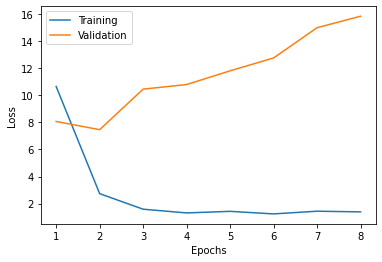

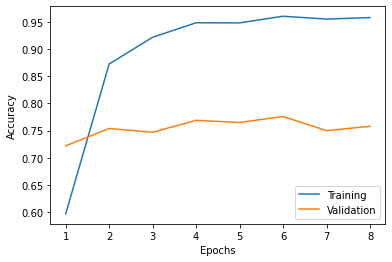

In [26]:
plot_history(second_history)

In [27]:
loss, acc = second_model.evaluate(test_data)
print("Obtained accuracy with the second model is: ", acc)
print("Obtained loss function value with the second model is: ", loss)

41/41 [==============================] - 10s 240ms/step - loss: 21.1458 - accuracy: 0.7044
Obtained accuracy with the second model is:  0.7044410705566406
Obtained loss function value with the second model is:  21.145776748657227


Here overfitting is even more visible, but 70% of accuracy on the train set with 10 classes (equal distibution).

### Third model
Now the diffrences suppose to be more visiable. 

In [28]:
third_model = build_model('block3_pool')

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [29]:
third_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
third_history = third_model.fit(train_data, validation_data=val_data, epochs=epochs, batch_size=batch_size)

Epoch 1/8
282/282 [==============================] - 42s 148ms/step - loss: 209.8002 - accuracy: 0.4518 - val_loss: 110.6819 - val_accuracy: 0.5670
Epoch 2/8
282/282 [==============================] - 42s 148ms/step - loss: 52.1268 - accuracy: 0.7609 - val_loss: 140.0491 - val_accuracy: 0.6380
Epoch 3/8
282/282 [==============================] - 42s 148ms/step - loss: 31.2548 - accuracy: 0.8499 - val_loss: 97.1692 - val_accuracy: 0.7010
Epoch 4/8
282/282 [==============================] - 42s 149ms/step - loss: 22.5640 - accuracy: 0.8996 - val_loss: 136.7090 - val_accuracy: 0.6520
Epoch 5/8
282/282 [==============================] - 42s 148ms/step - loss: 20.9381 - accuracy: 0.9060 - val_loss: 126.0144 - val_accuracy: 0.7010
Epoch 6/8
282/282 [==============================] - 42s 148ms/step - loss: 16.4639 - accuracy: 0.9284 - val_loss: 244.3802 - val_accuracy: 0.5930
Epoch 7/8
282/282 [==============================] - 42s 149ms/step - loss: 22.2621 - accuracy: 0.9218 - val_loss: 145

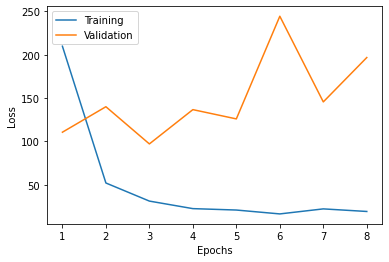

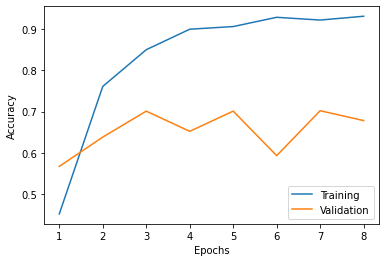

In [30]:
plot_history(third_history)

In [31]:
loss, acc = third_model.evaluate(test_data)
print("Obtained accuracy with the third model is: ", acc)
print("Obtained loss function value with the third model is: ", loss)

41/41 [==============================] - 10s 230ms/step - loss: 255.0383 - accuracy: 0.6279
Obtained accuracy with the third model is:  0.6278713345527649
Obtained loss function value with the third model is:  255.0382843017578


Here the overfitting is getting really bad.

### Summary
I started with the last pooling layer to make to computation cost as low as possible, and then I was taking previous layers. An important thing to observe is that the further models have fewer parameters, but more trainable ones, which makes them more customized to the given problem. The vgg16 network is so well designed that when I used its prelearned features it was working amazingly. However, having a more complex problem may need more trainable parameters, and then it is a more reasonable idea to have fewer vgg16 layers. 

In all these models we can see some overfitting. The least params the bigger overfitting, which is reasonable. The pretrained params are extracting the features well and that is why the first model is the best. The best idea it would be to make data augmentation here, because for such a complex problem 1000 training photos is not enough. 

If I had more time I would play more with all the hyperparameter.